In [18]:
%load_ext nb_black

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob
import random
from tqdm.auto import tqdm
from scipy.stats import norm

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
def set_size(width, fraction=1, subplots=(1, 1)):  # for science plots?
    """Set figure dimensions to avoid scaling in LaTeX.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "full":
        width_pt = 513.11743
    elif width == "half":
        width_pt = 242.26653
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv(
    "/hyrule/data/users/kshitij/kg_121102/121102_paper/all_bursts_bary.csv"
)
tru = data["use_fluence"]  # use only the good ones marked as true
useful_data = data[tru]
use = useful_data["fit_method"] != "curvefit"  # use only mcmc
to_use = useful_data[use]
bandgood1 = (
    to_use["$\mu_f$ (MHz)"] + 1.0 * to_use["$\sigma_f$ (MHz)"]
) < 1780  # top of band 1780 MHz
band1 = to_use[bandgood1]
bandgood2 = (
    band1["$\mu_f$ (MHz)"] - 1.0 * band1["$\sigma_f$ (MHz)"]
) > 980  # bottom of band 980 MHz
band2 = band1[bandgood2]
candids = np.array(
    band2["cand_id"]
)  # compare the cand id to the files in the directory which has distributions
path = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/"
final_file = []
for i in candids:
    file = path + i + "_fluence_times_bw.npy"
    final_file = np.append(final_file, file)
    # data = np.load(file)
print(final_file.shape)

(64,)


<IPython.core.display.Javascript object>

In [4]:
# all the multi-comp bursts

multi1 = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/cand_tstart_57644.407719907409_tcand_248.2970000_dm_562.05600_snr_97.12390_fluence_times_bw.npy"
multi2 = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/cand_tstart_57644.407719907409_tcand_4886.4000000_dm_565.30000_snr_15.69560_fluence_times_bw.npy"
multi3 = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/cand_tstart_57645.409861111111_tcand_159.4330000_dm_558.83100_snr_7.95436_fluence_times_bw.npy"
multi4 = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/cand_tstart_57645.409861111111_tcand_1460.2500000_dm_555.62500_snr_12.63900_fluence_times_bw.npy"
multi5 = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/cand_tstart_57645.409861111111_tcand_1743.9100000_dm_558.83100_snr_13.70630_fluence_times_bw.npy"
multi6 = "/hyrule/data/users/kshitij/kg_121102/121102_paper/fluence_times_bw/cand_tstart_57645.409861111111_tcand_4286.4700000_dm_562.05600_snr_168.68900_fluence_times_bw.npy"
multi_burst_names = list([multi1, multi2, multi3, multi4, multi5, multi6])
# multi = list([multi1,multi5,multi6])

<IPython.core.display.Javascript object>

In [5]:
# deleting all the multi-comp bursts from the final_file list.


test1 = np.delete(final_file, np.where(final_file == multi1))
test2 = np.delete(test1, np.where(test1 == multi2))
test3 = np.delete(test2, np.where(test2 == multi3))
test4 = np.delete(test3, np.where(test3 == multi4))
test5 = np.delete(test4, np.where(test4 == multi5))
only_single_comp = np.delete(test5, np.where(test5 == multi6))

<IPython.core.display.Javascript object>

In [6]:
def Energy(x):  # function to compute energies
    return (
        x * 4 * np.pi * ((972 * 3.086e24) ** 2) * 10 ** (-23) * 10 ** (3)
    )  # 10**(3) to convert MHz.ms to Hz.s

<IPython.core.display.Javascript object>

In [7]:
# let's find the single-component energies

single = np.array(
    [list(np.load(i)) for i in only_single_comp]
)  # loading only single comp files
en_sin = Energy(single)  # Energy distribution of all single comp bursts

<ipython-input-7-1aacb6a1306e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  single = np.array([list(np.load(i)) for i in only_single_comp]) # loading only single comp files


<IPython.core.display.Javascript object>

In [8]:
# multi component energies. We are only using the components and bursts that was totally inside the band

mul = []
mu = [list(np.load(i)) for i in multi_burst_names]
en1 = Energy(mu[0][0]) + Energy(mu[0][1])  # summing both components of 97 sig
en4 = Energy(mu[3][0])  # using only one comp of this
en5 = Energy(mu[4][0]) + Energy(mu[4][1])  # using both comp
en6 = (
    Energy(mu[5][0]) + Energy(mu[5][1]) + Energy(mu[5][2])
)  # summing all three comp of 168 sig
en_mul = np.append(mul, [en1, en5, en6, en4])
print(en_mul.shape)

(4,)


/home/dagarwal/soft/conda/envs/your_env/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

In [9]:
# appending single and multiple to an array

en_tot = np.append(en_sin, en_mul)
en_tot.shape

(60,)

<IPython.core.display.Javascript object>

In [10]:
def randomized_energies(
    x,
):  # define a function that will randomly select points from each bursts and compute energies of those
    randomized = []
    for i in x:
        rand = random.choice(i)
        randomized = np.append(randomized, rand)
    return randomized

<IPython.core.display.Javascript object>

In [11]:
def rate(x):
    N_tot = []  # computing number of bursts above energy E
    for i in x:
        rx = x >= i
        # print(rx)
        res = [j for j, val in enumerate(rx) if val]
        Rx = len(res)
        N_tot = np.append(N_tot, Rx)
    return N_tot

<IPython.core.display.Javascript object>

In [12]:
def double_power(
    E, E_break, alpha, beta, E_scale
):  # function to define a double-power law
    fit = []
    for energy in E:
        if energy < E_break:
            N = E_scale * ((energy / E_break) ** alpha)
        else:
            N = E_scale * ((energy / E_break) ** beta)
        fit.append(N)
    return np.array(fit)

<IPython.core.display.Javascript object>

In [13]:
# compute the values of the broken-power law function parameters

alphas = []
betas = []
E_break = []
E_scale = []
energies = [
    randomized_energies(en_tot) for i in range(1000)
]  # find random energies from all the single bursts 1000 times
for i in energies:
    complete = i[np.where(i > 5.81e36)]  # above completeness threshold for the fitting
    u = complete * 10 ** (-37)  # for fitting
    popt, pcov = curve_fit(
        double_power,
        u,
        rate(u),
        bounds=((1, -5, -5, -np.inf), (3, 0, 0, np.inf)),
        maxfev=15000,
    )  # a double power law fit
    alphas = np.append(alphas, popt[1])
    betas = np.append(betas, popt[2])
    E_break = np.append(E_break, popt[0])
    E_scale = np.append(E_scale, popt[3])

<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

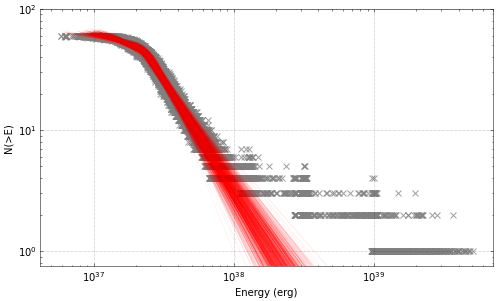

<IPython.core.display.Javascript object>

In [26]:
# let's plot with the best-fit values computed from previous step

with plt.style.context(["science", "grid", "no-latex"]):
    plt.figure(
        figsize=set_size(width="full")
    )  # for half page width figures use full for full page width figures

    for i, energy in enumerate(tqdm(energies)):
        complete = energy[
            np.where(energy > 5.81e36)
        ]  # above completeness threshold for the fitting
        u = complete * 10 ** (-37)  # for fitting

        alpha = alphas[i]
        beta = betas[i]
        E_th = E_break[i]
        amp = E_scale[i]
        popt = []

        plt.plot(
            np.sort(u * 10 ** (37)),
            double_power(np.sort(u), E_th, alpha, beta, amp),
            linewidth=0.05,
            color="red",
            alpha=0.75,
        )

        plt.yscale("log")  # plots are in log scale
        plt.xscale("log")
        plt.scatter(u * 10 ** 37, rate(u), color="grey", alpha=0.75, marker="x")
    plt.scatter(
        u * 10 ** 37, rate(u), color="grey", alpha=0.75, label="data", marker="x"
    )
    plt.plot(
        np.sort(u * 10 ** (37)),
        double_power(np.sort(u), E_th, alpha, beta, amp),
        linewidth=0.5,
        color="red",
        alpha=0.75,
        label="fit",
    )

    plt.xlabel("Energy (erg)")
    plt.ylabel("N(>E)")
    # plt.legend(loc="upper right")
    plt.ylim([0.75, 100])
    plt.tight_layout()
    plt.savefig("cumulative_energies.png", bbox_inches="tight", dpi=300)
    plt.show()

In [15]:
np.median(alphas), np.median(betas), np.median(E_break), np.median(E_scale)

(-0.406829852666846,
 -1.8367860312647597,
 2.2914449201830447,
 46.288534821071565)

<IPython.core.display.Javascript object>